## **Mapeando datos**

➡️ Apuntar

🗒️ **Observaciones:**

⚠️ **Alertas:**

### **1. Importamos las respectivas librerías**

In [72]:
import pandas as pd
import zipfile
from pathlib import Path
import shutil
import folium
import sqlite3

### **2. Descomprimimos los archivos correspondientes**

➡️ Creamos una variable path que nos ayude a indentificar donde estan todos los archivos zip.

In [73]:
raw_path = '/home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Raw/'
silver_path = '/home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/'

data_files = Path(raw_path)

➡️ Necesitamos recorrer la carpeta ya que habra mas de un archivo zip, luego vamos a descomprimirlos, almacenarlos en un dataframe y juntarlos todos. Usamos la libreria Path.

In [74]:
for file in data_files.rglob('*'):
    new_name = file.name.replace(" ","").replace("_","")
    new_path = file.with_name(new_name)
    file.rename(new_path)
    with zipfile.ZipFile(f'{raw_path+file.name}','r') as extraction:
        extraction.extractall(silver_path)

➡️ Eliminamos los archivos que tienen un formato diferente a csv.

🗒️ **Observaciones:** La librería path tambien es útil en este caso.

In [75]:
silver_files = Path(silver_path)
for file in silver_files.iterdir():
    # Verificar si es un archivo y no termina en '.csv'
    if file.is_file() and file.suffix != '.csv':
        # Eliminar el archivo
        file.unlink()
        print(f'Eliminado: {file}')

Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2020_SemII.dta
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2019_SemII.dta
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2021 ( I Semestre).dta
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2019_SemII.sav
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2019_SemI.dta
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2018_SemI.sav
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2018_SemII.dta
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2020_SemI.dta
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2020_SemII.sav
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2019_SemI.sav
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2018_SemII.sav
Eliminado: /home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Silver/2021 ( I Semestre).sav
Eliminado: /home

⚠️ **Alertas:** Algunos archivos se descomprimen dentro de una carpeta, por lo tanto nos toca moverlos hacia el directorio Silver

In [76]:
for file in silver_files.iterdir():
    if file.is_file():
        pass
    else:
        subfolder = silver_files.joinpath(file.name)
        for subfile in subfolder.glob('*'):
            if subfile.suffix == '.csv':
                subfile.replace(silver_path+"/"+subfile.name)
                print(f'Archivo: {subfile.name} movido exitosamente')

        shutil.rmtree(subfolder)
        print(f'Carpeta: {subfolder.name} elminada')

Archivo: 2021(II Semestre).csv movido exitosamente
Carpeta: 2021 (II.semestre) elminada
Archivo: SIPSA_A_Isem2022.csv movido exitosamente
Carpeta: 2022 ( I Semestre ) elminada
Archivo: SIPSA_A Isem2024.csv movido exitosamente
Carpeta: 2024 ( I Semestre ) elminada
Archivo: SIPSA_A_IIsem2023.csv movido exitosamente
Carpeta: 2023 ( II Semestre ) elminada
Archivo: SIPSA_A_Isem2023.csv movido exitosamente
Carpeta: SIPSA_A_Isem2023 elminada


### **3. Unificamos la informacion que necesitamos**

➡️ Creamos un dataframe vacio y ahi concatenamos toda la informacion que necesitamos.

In [77]:
df = pd.DataFrame()

⚠️ **Alertas:** Es posible que las bases de datos no tengan exactamente las mismas columnas. Previamente preparamos un diccionario que nos va a ayudar a normalizar los nombres.

In [78]:
columnas_ajustadas = {
    'Fuente':'Mayorista',
    'FechaEncuesta':'Fecha',
    'Fecha':'Fecha',
    'Cod. Depto Proc.':'Codigo departamento',
    'Cod. Municipio Proc.':'Codigo municipio',
    'Departamento Proc.':'Departamento',
    'Municipio Proc.':'Municipio',
    'Grupo':'Grupo',
    'Ali':'Alimento',
    'Cant Kg':'Cant Kg',
    'Código Departamento':'Codigo departamento',
    ' Código Municipio ':'Codigo municipio',
    'Alimento':'Alimento',
    'Cuidad, Mercado Mayorista':'Mayorista',
    'Origen':'Origen',
    'Unnamed: 9':'Unnamed: 9',
    'Unnamed: 10':'Unnamed: 10',
    'Codigo CPC':'Codigo CPC'
}

➡️ Ajustamos los nombres de todos los archivos de acuerdo al diccionario que acabamos de definir.

In [79]:
for file in silver_files.iterdir():
    df_temp = pd.read_csv(file, encoding='unicode_escape', sep=";")
    df_temp['Origen'] = file.name
    for column in df_temp.columns:
        df_temp.rename(columns={column: columnas_ajustadas[column]}, inplace=True)
    df =pd.concat([df,df_temp], ignore_index=True)

/tmp/ipykernel_3279/1997498870.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_temp = pd.read_csv(file, encoding='unicode_escape', sep=";")


➡️ Eliminamos las columnas que no vamos a utilizar.

In [80]:
df = df.drop(['Unnamed: 9','Unnamed: 10','Codigo CPC'],axis=1)

➡️ Homologamos dentro de la columna *"Fuente"* a *"Cali, Santa Elena"* por *"Cali, Santa Helena"*



In [81]:
df.loc[df["Mayorista"] == "Cali, Santa Elena", "Mayorista"] = "Cali, Santa Helena"

➡️ Enviamos la informacion a un archivo csv para ver como se está juntando el resultado.

In [82]:
database_path = '/home/npalaciosv/Catedra/Geoanalitycs/Docs/Database/geo.db'
conn = sqlite3.connect(database_path)
df.to_sql('Fact', con=conn, if_exists='replace', index=False)

11764957

In [83]:
def moviendo_db(database_path, user_path):
    shutil.move(database_path, user_path)
    print(f'Archivo movido a {user_path}')

In [84]:
user_path = '/mnt/d/Classes/Data visualization/Mapping data/Database/geo.db'

moviendo_db(database_path=database_path,user_path=user_path)

SameFileError: '/home/npalaciosv/Catedra/Geoanalitycs/Docs/Database/geo.db' and '/home/npalaciosv/Catedra/Geoanalitycs/Docs/Database/geo.db' are the same file

### **4. Iniciamos con la construccion de los mapas**

#### **4.1 Establecemos las coordenadas de los centros mayoristas**

➡️ Primero importamos las coordenadas de cada uno de los centros de acopia que se mencionan en la base de datos

In [ ]:
coordenadas_path = "/home/npalaciosv/Catedra/Geoanalitycs/Docs/Data/Static/Coordenadas.csv"
df_coor = pd.read_csv(coordenadas_path,sep=";",encoding='utf-8')
df_coor.to_sql('Coordenadas_mayoristas', con=conn, if_exists='replace', index=False)

OperationalError: attempt to write a readonly database

➡️ Creamos el objeto mapa utilizando la libreria folium. Especificamos un punto central para que aparezca el mapa.

In [ ]:
map = folium.Map(location=[4.922860659232988, -74.02580517889908], zoom_start=7)

➡️ Llamamos el icono de una plaza de mercado que escogimos para ponerlo como icono de marcacion.


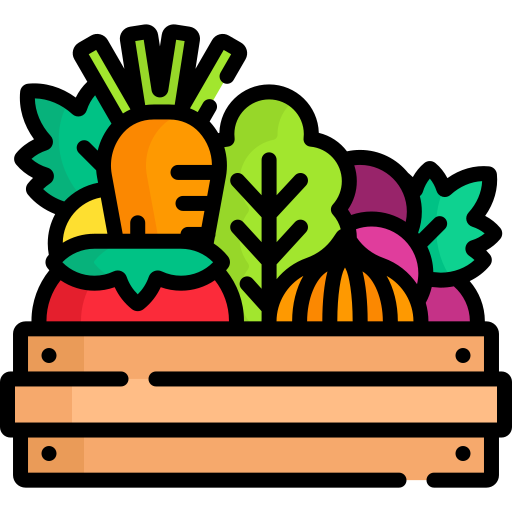
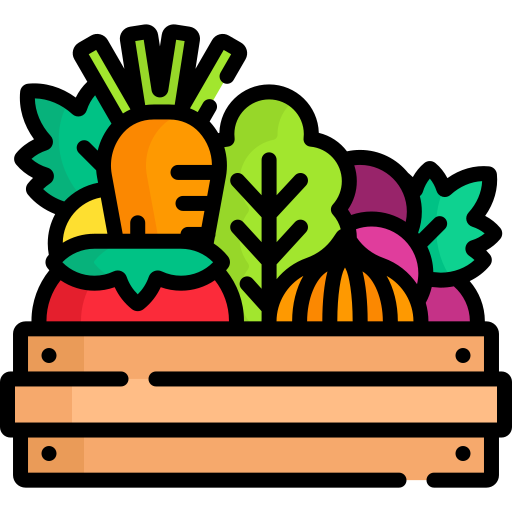
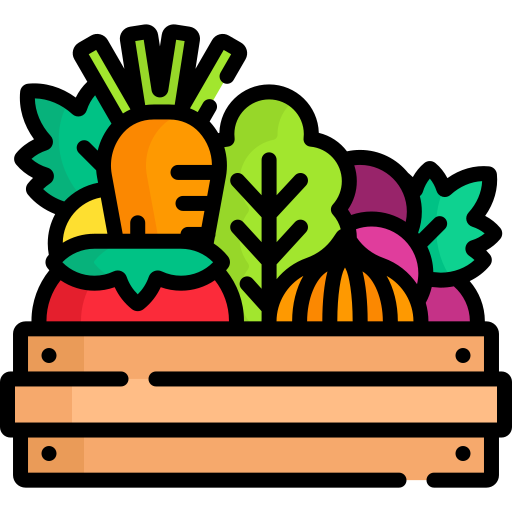
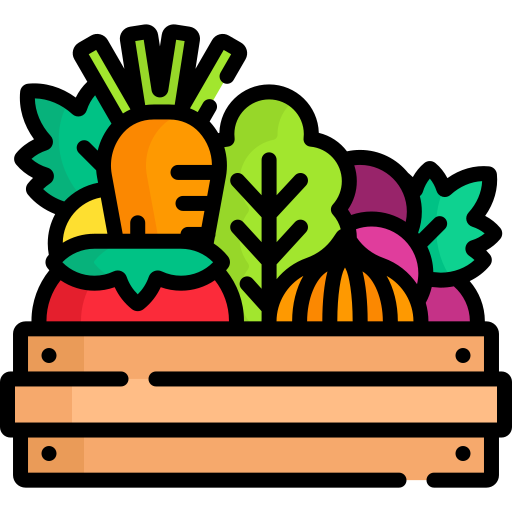
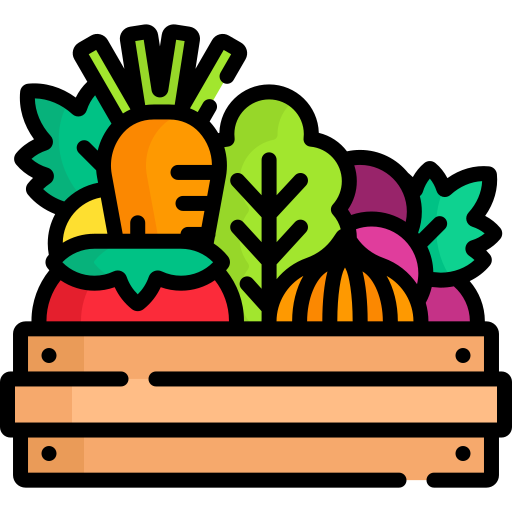
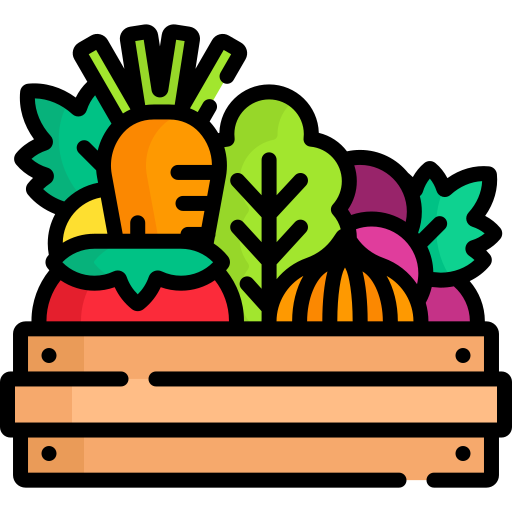
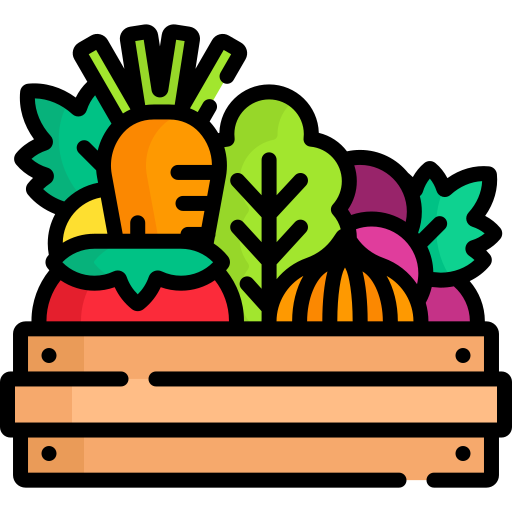
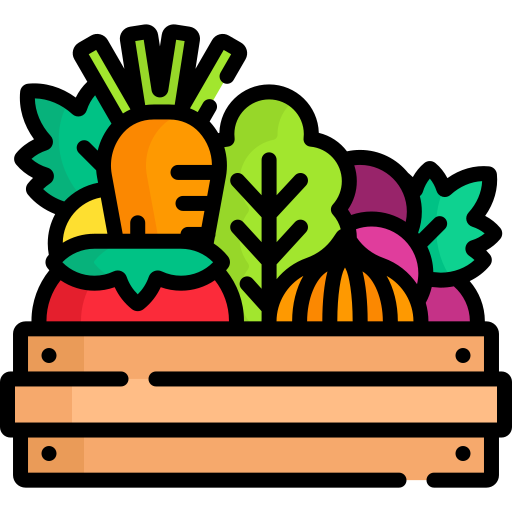
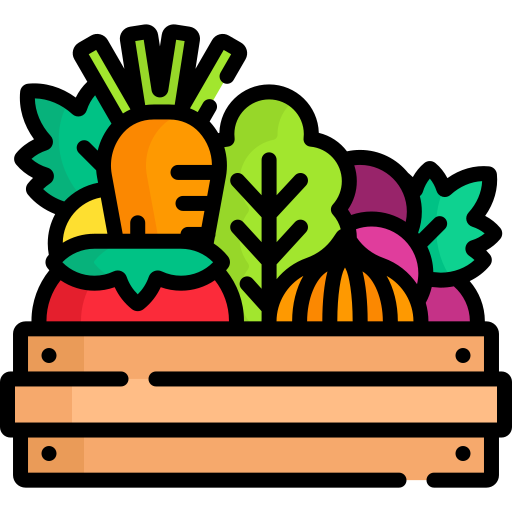
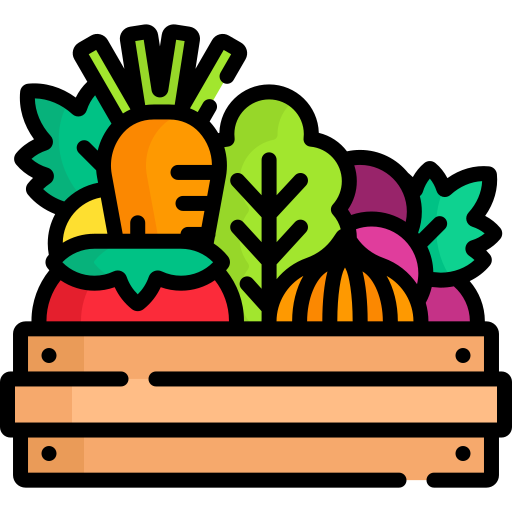
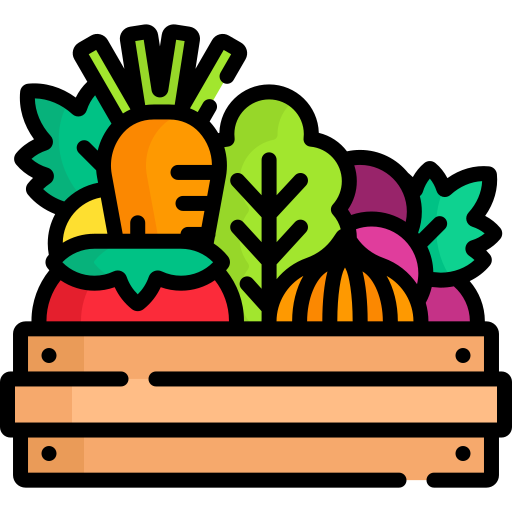
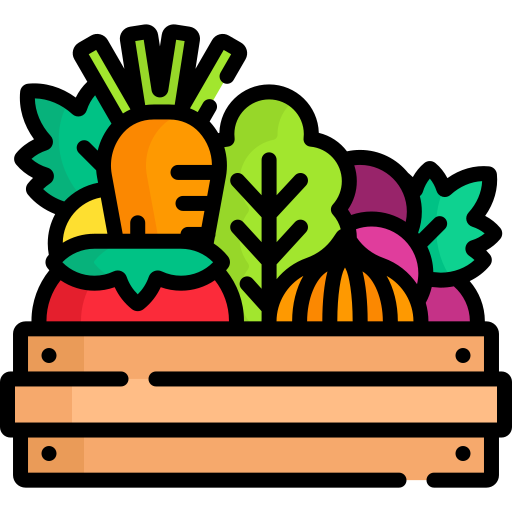
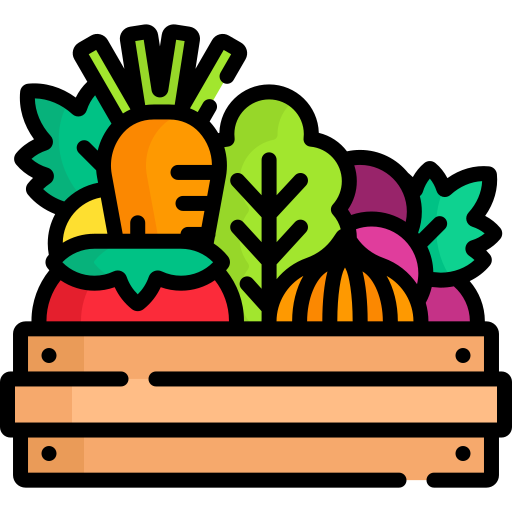
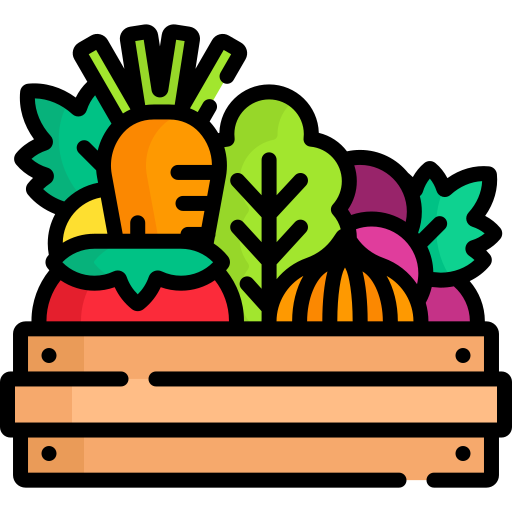
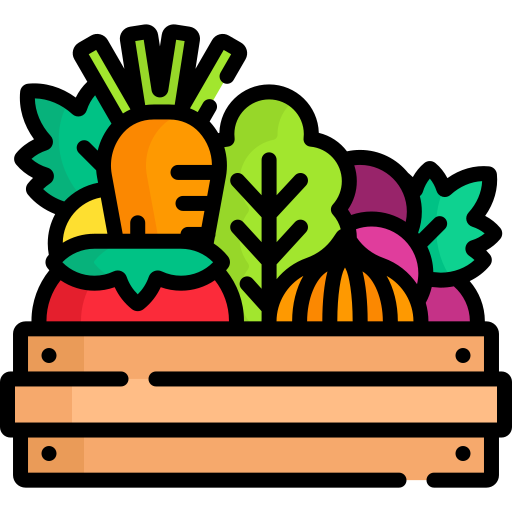
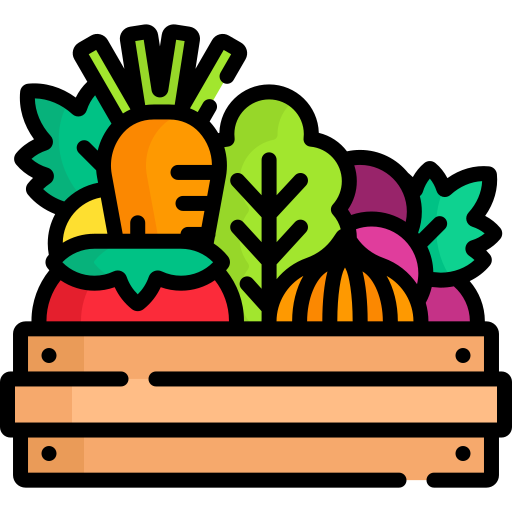
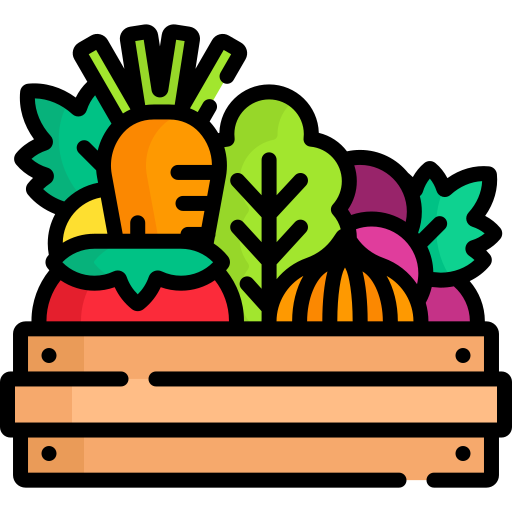
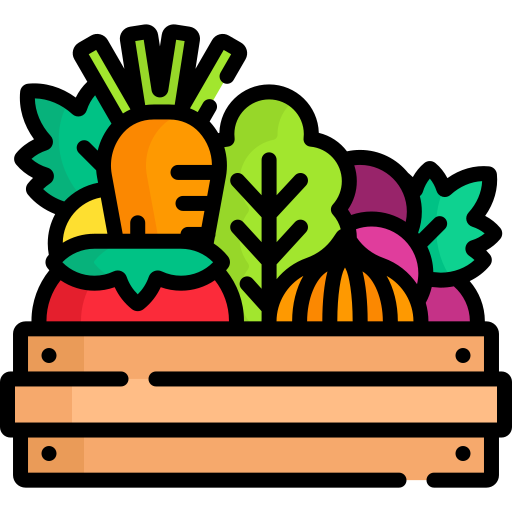
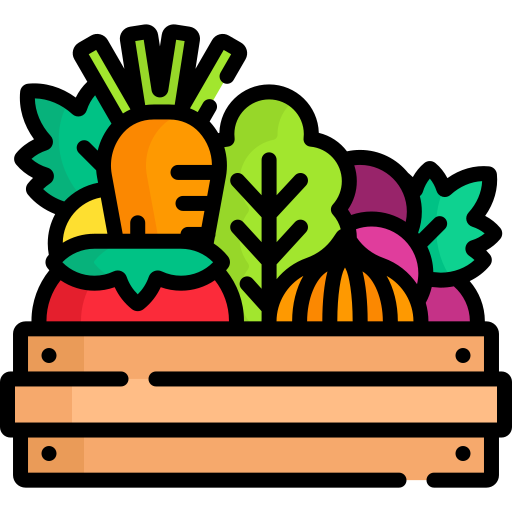
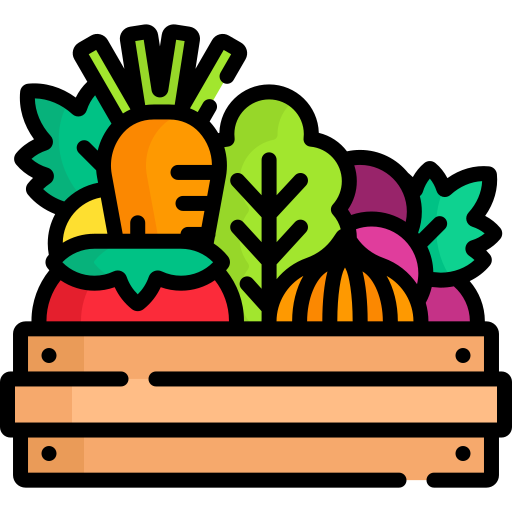
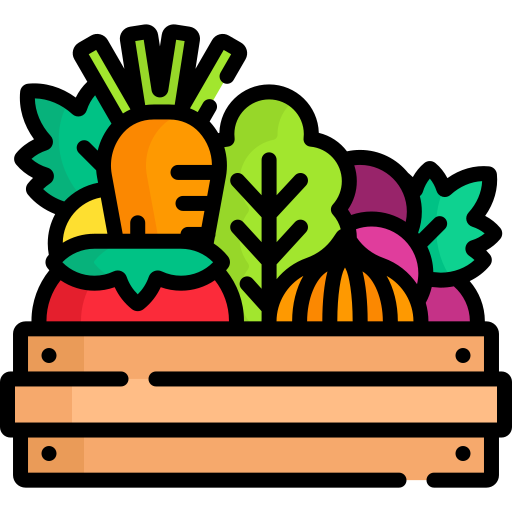
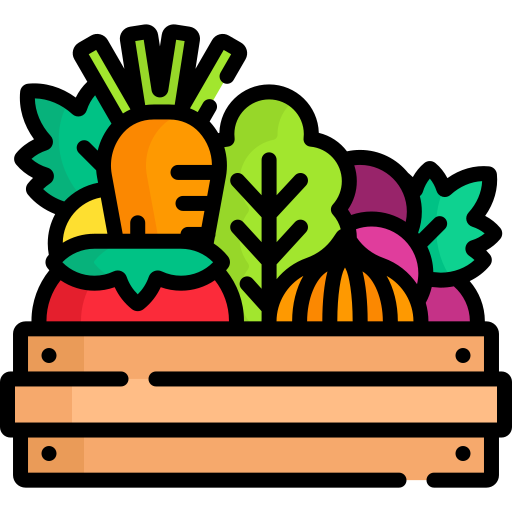
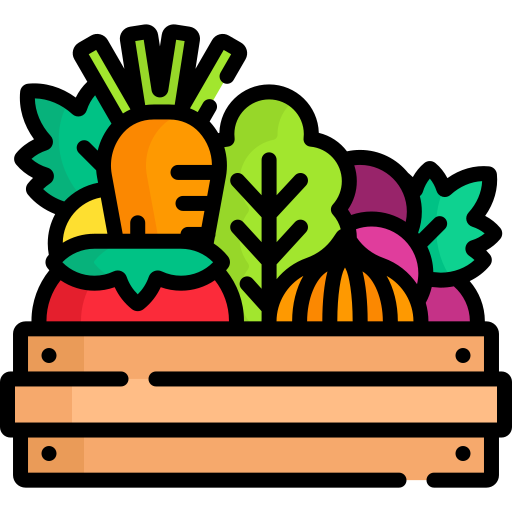
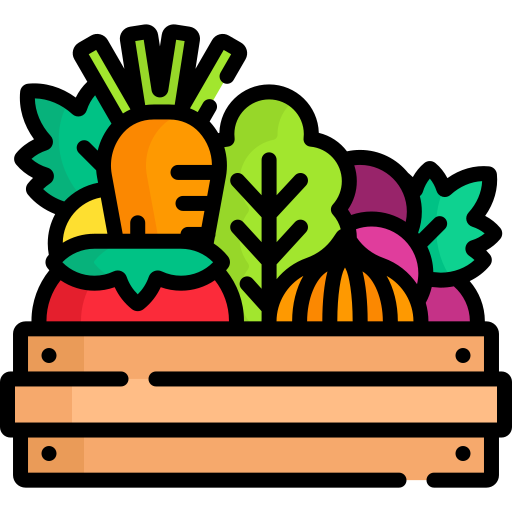
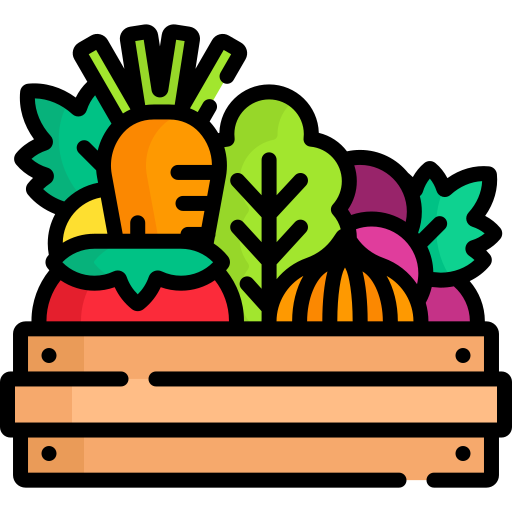
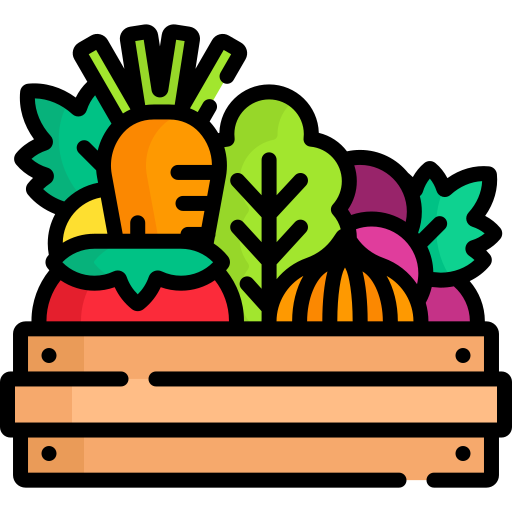
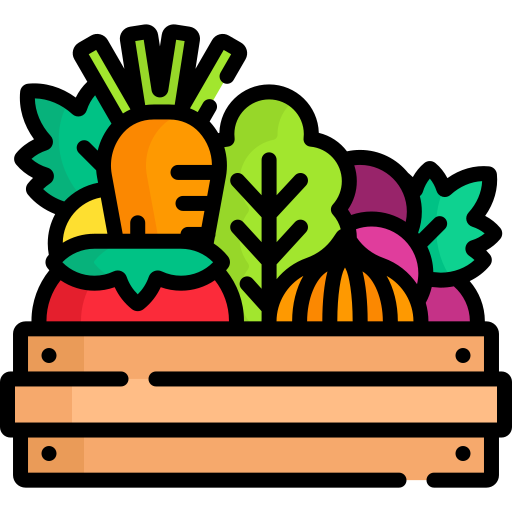
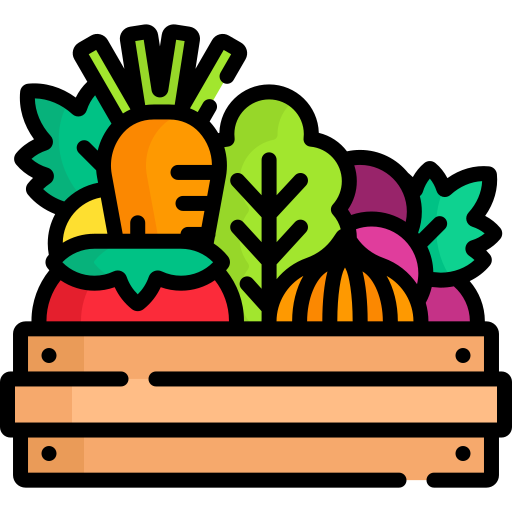
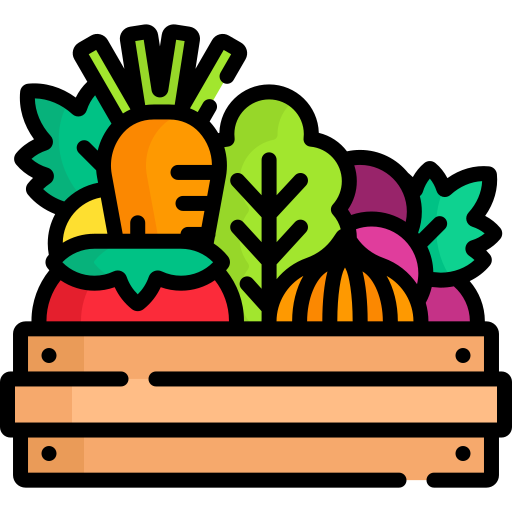
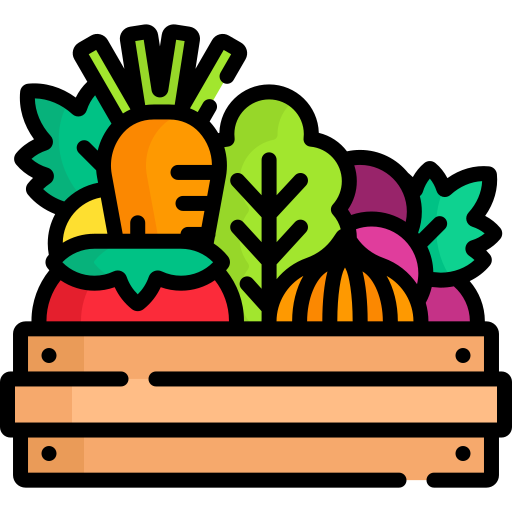
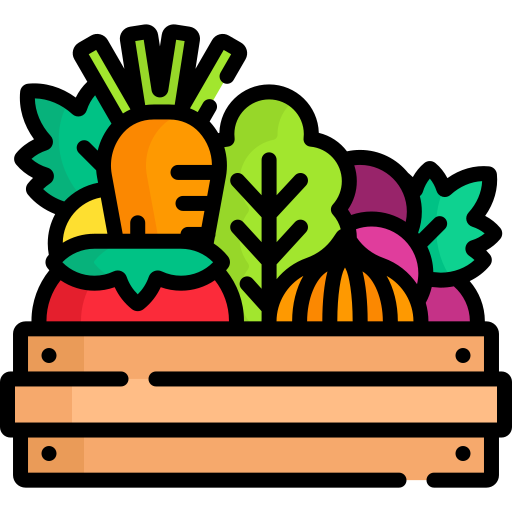
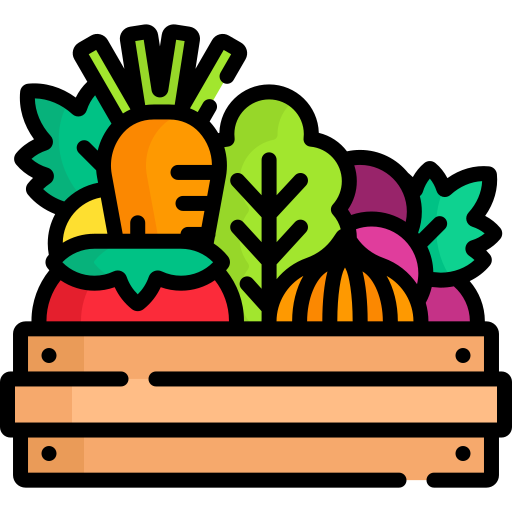

In [ ]:
#
icon_path = '/home/npalaciosv/Catedra/Geoanalitycs/Docs/Icons/Mayorista.png'

#
lat = df_coor['Latitud'].to_list()
lon = df_coor['Longitud'].to_list()
fuente = df_coor['Mayorista'].to_list()
coordenadas = list(zip(lat,lon,fuente))

#
for lat,lon,fuente in coordenadas:
    folium.Marker(
        [lat,lon],
        popup=f'{fuente}',
        icon=folium.CustomIcon(icon_image=icon_path,icon_size=(20,20))
    ).add_to(map)
map

#### **4.2 Establecemos las coordenadas de los municipios abastecedor**